In [ ]:
from google.colab import files
uploaded = files.upload()  # select the CSV files from your local machine


Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')


In [ ]:
# Check basic info
for name, df in {
    "Customers": customers,
    "Geolocation": geolocation,
    "Order Items": order_items,
    "Payments": payments,
    "Reviews": reviews,
    "Orders": orders,
    "Products": products,
    "Sellers": sellers,
    "Category Translation": category_translation
}.items():
    print(f"--- {name} ---")
    print(df.shape)  # number of rows & columns
    print(df.isnull().sum())  # missing values per column
    print(df.head(3))  # first 3 rows
    print("\n")


--- Customers ---
(99441, 5)
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  


--- Geolocation ---
(1000163, 5)
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
   geolocation_zip_code_prefix

In [ ]:
# Drop rows where product_id is missing (critical key)
products.dropna(subset=["product_id"], inplace=True)

# Fill missing product category with 'unknown'
products["product_category_name"].fillna("unknown", inplace=True)


/tmp/ipython-input-4137095886.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products["product_category_name"].fillna("unknown", inplace=True)


In [ ]:
products = products.merge(category_translation,
                          how="left",
                          on="product_category_name")


In [ ]:
date_cols = ["order_purchase_timestamp", "order_approved_at",
             "order_delivered_customer_date"]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")


### Exploratory Data Analysis

In [ ]:
orders["order_purchase_timestamp"].min(), orders["order_purchase_timestamp"].max()
orders["order_status"].value_counts(normalize=True) * 100
order_details = orders.merge(order_items, on="order_id", how="inner")
order_details["total"] = order_details["price"] + order_details["freight_value"]

order_details.groupby("order_status")["total"].sum().sort_values(ascending=False)


,total
order_status,
delivered,15419773.75
shipped,177129.34
canceled,105885.72
processing,69394.11
invoiced,68988.75
unavailable,2140.49
approved,241.08


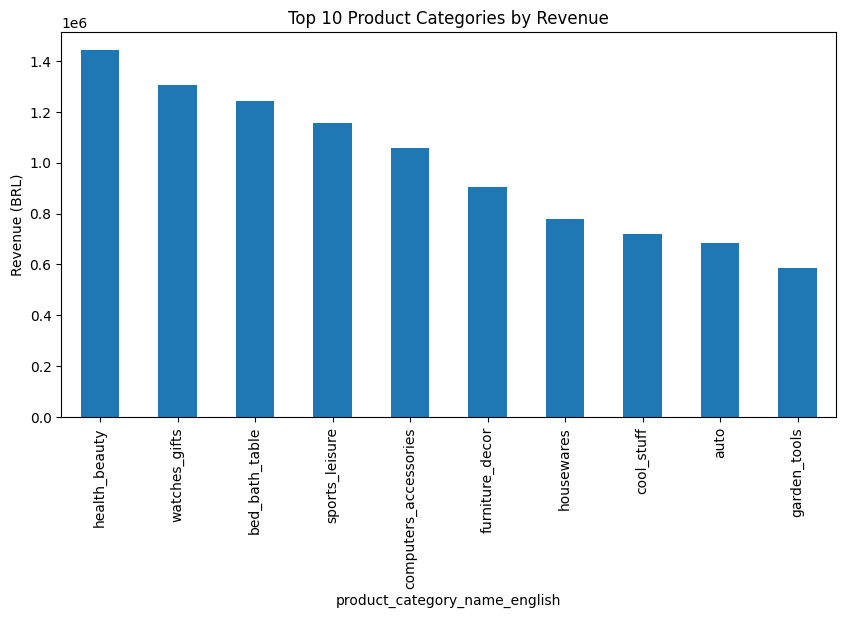

In [ ]:
import matplotlib.pyplot as plt

top_categories = (order_details
    .merge(products, on="product_id")
    .groupby("product_category_name_english")["total"]
    .sum()
    .sort_values(ascending=False)
    .head(10))

top_categories.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Product Categories by Revenue")
plt.ylabel("Revenue (BRL)")
plt.show()


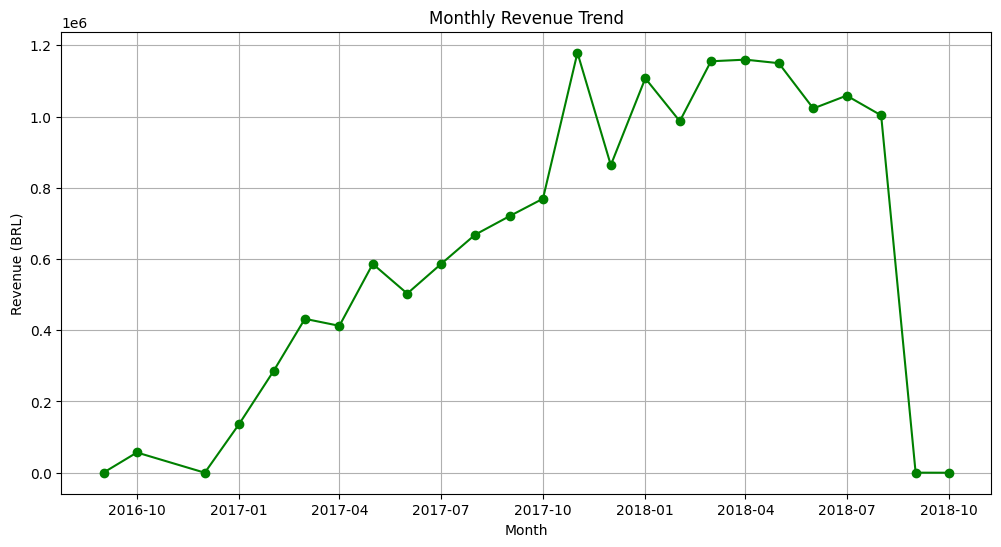

In [ ]:
#  Convert order purchase timestamp to datetime
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])

#  Merge orders with order_items to get revenue info
orders_with_items = orders.merge(order_items, on="order_id", how="left")

#  Create 'total' column (price + freight)
orders_with_items["total"] = orders_with_items["price"] + orders_with_items["freight_value"]

#  Extract Year-Month for grouping
orders_with_items["YearMonth"] = orders_with_items["order_purchase_timestamp"].dt.to_period("M")

# Group by month
monthly_revenue = (
    orders_with_items
    .groupby("YearMonth")["total"]
    .sum()
    .reset_index()
)

#  Convert YearMonth to datetime for plotting
monthly_revenue["YearMonth"] = monthly_revenue["YearMonth"].dt.to_timestamp()

#  Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue["YearMonth"], monthly_revenue["total"], marker="o", color="green")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.grid(True)
plt.show()


### Customer Segmentation (RFM Analysis)

In [ ]:
from datetime import datetime
# Handle duplicate edges in qcut


#  Prepare orders with customer info & revenue
rfm_df = orders_with_items.merge(customers, on="customer_id", how="left")

#  Latest purchase date in dataset
latest_date = rfm_df["order_purchase_timestamp"].max()

rfm = (
    rfm_df.groupby("customer_id")
    .agg({
        "order_purchase_timestamp": lambda x: (latest_date - x.max()).days,  # Recency
        "order_id": "count",                                                # Frequency
        "total": "sum"                                                      # Monetary
    })
    .reset_index()
)

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

#  Assign RFM scores (1–4 scale) with duplicates handling
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])  # Lower Recency → Higher Score
# Frequency score using rank
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1, 2, 3, 4])


# Combine into a single RFM score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

# Show top customers
rfm.sort_values("RFM_Score", ascending=False).head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
83902,d75654891902c3b820abd3545048c592,162,1,189.01,4,4,4,444,12
99390,ffde64401f7cb62d2e8696d9467c781d,162,2,476.14,4,4,4,444,12
99438,ffff42319e9b2d713724ae527742af25,126,1,214.13,4,4,4,444,12
92648,ee1f68f29aaa80e5047ad2ba7f482ed7,56,1,290.84,4,4,4,444,12
25020,407c757765d8367d4044c50a0e406004,59,2,302.10,4,4,4,444,12
74517,bf239a3d9e5fab72059537d02b201d37,78,2,270.13,4,4,4,444,12
7367,1314355cd90fe9019e54bd1521df0ab6,68,2,201.40,4,4,4,444,12
83933,d76dd851914eeae70178f37194d5cb66,117,1,289.89,4,4,4,444,12
83932,d76dc2ed3d9f58905f39deea067fd40f,87,1,201.42,4,4,4,444,12
58915,97b2b730a9199d685c6ad1edb3b2b2c2,124,2,514.98,4,4,4,444,12


In [ ]:
#  Merge orders with customer data
delivery_df = orders.merge(customers, on="customer_id", how="left")

#  Ensure all relevant date columns are datetime
date_cols = [
    "order_purchase_timestamp",
    "order_estimated_delivery_date",
    "order_delivered_customer_date"
]
for col in date_cols:
    delivery_df[col] = pd.to_datetime(delivery_df[col])

#  Calculate promised delivery days
delivery_df["promised_delivery_days"] = (
    delivery_df["order_estimated_delivery_date"] - delivery_df["order_purchase_timestamp"]
).dt.days

#  Calculate actual delivery days
delivery_df["actual_delivery_days"] = (
    delivery_df["order_delivered_customer_date"] - delivery_df["order_purchase_timestamp"]
).dt.days

#  Calculate delay days (if positive, order was late)
delivery_df["delay_days"] = (
    delivery_df["order_delivered_customer_date"] - delivery_df["order_estimated_delivery_date"]
).dt.days

#  Summary KPIs
avg_delivery_time = delivery_df["actual_delivery_days"].mean()
avg_delay = delivery_df.loc[delivery_df["delay_days"] > 0, "delay_days"].mean()
on_time_rate = (delivery_df["delay_days"] <= 0).mean() * 100

print(f" Average Delivery Time: {avg_delivery_time:.1f} days")
print(f" Average Delay (if late): {avg_delay:.1f} days")
print(f" On-time Delivery Rate: {on_time_rate:.1f}%")

#  Top 10 states with most delays
delay_by_state = (
    delivery_df.groupby("customer_state")["delay_days"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
delay_by_state


📦 Average Delivery Time: 12.1 days
⏳ Average Delay (if late): 10.6 days
✅ On-time Delivery Rate: 90.4%


,delay_days
customer_state,
AL,-8.707809
MA,-9.571827
SE,-10.020896
ES,-10.496241
BA,-10.794533
CE,-10.804535
MS,-11.052782
SP,-11.076380
PI,-11.306723


In [ ]:
#  Merge orders with payments
payment_df = orders.merge(payments, on="order_id", how="left")

#  Average order value
avg_order_value = payment_df.groupby("order_id")["payment_value"].sum().mean()

#  Payment method usage
payment_method_split = (
    payment_df.groupby("payment_type")["payment_value"]
    .sum()
    .sort_values(ascending=False)
)

#  Installments usage
installment_split = payment_df["payment_installments"].value_counts().sort_index()

#  Output
print(f" Average Order Value (AOV): {avg_order_value:.2f} BRL")
print("\nPayment Method Revenue Split:")
print(payment_method_split)
print("\nInstallment Usage:")
print(installment_split)


💰 Average Order Value (AOV): 160.99 BRL

Payment Method Revenue Split:
payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64

Installment Usage:
payment_installments
0.0         2
1.0     52546
2.0     12413
3.0     10461
4.0      7098
5.0      5239
6.0      3920
7.0      1626
8.0      4268
9.0       644
10.0     5328
11.0       23
12.0      133
13.0       16
14.0       15
15.0       74
16.0        5
17.0        8
18.0       27
20.0       17
21.0        3
22.0        1
23.0        1
24.0       18
Name: count, dtype: int64


In [ ]:
import pandas as pd
from io import BytesIO

# Load datasets from uploaded (bytes → file-like object)
order_payments = pd.read_csv(BytesIO(uploaded["olist_order_payments_dataset.csv"]))
orders = pd.read_csv(BytesIO(uploaded["olist_orders_dataset.csv"]))

# Merge payment data with orders
payment_df = order_payments.merge(orders, on="order_id", how="left")

# Payment method breakdown
payment_method_breakdown = (
    payment_df.groupby("payment_type")["payment_value"]
    .agg(["count", "sum", "mean"])
    .sort_values(by="sum", ascending=False)
)

# Installment statistics
installment_stats = (
    payment_df.groupby("payment_installments")["payment_value"]
    .agg(["count", "sum", "mean"])
    .sort_values(by="payment_installments")
)

# Summary metrics
most_common_payment = payment_df["payment_type"].mode()[0]
avg_payment_value = payment_df["payment_value"].mean()

print(f" Most Common Payment Method: {most_common_payment}")
print(f" Average Payment Value: {avg_payment_value:.2f} BRL")


💳 Most Common Payment Method: credit_card
💰 Average Payment Value: 154.10 BRL


In [ ]:
from io import BytesIO

# Load datasets
order_items = pd.read_csv(BytesIO(uploaded["olist_order_items_dataset.csv"]))
products = pd.read_csv(BytesIO(uploaded["olist_products_dataset.csv"]))
order_reviews = pd.read_csv(BytesIO(uploaded["olist_order_reviews_dataset.csv"]))

# Merge order items with products
product_df = order_items.merge(products, on="product_id", how="left")

# Merge with reviews to get review scores
product_df = product_df.merge(order_reviews[["order_id", "review_score"]], on="order_id", how="left")

# Top categories by revenue
category_revenue = (
    product_df.groupby("product_category_name")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Top categories by quantity sold
category_quantity = (
    product_df.groupby("product_category_name")["order_item_id"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

# Average review score per category
category_reviews = (
    product_df.groupby("product_category_name")["review_score"]
    .mean()
    .sort_values(ascending=False)
)

print(" Top 10 Categories by Revenue:")
print(category_revenue)

print("\n Top 10 Categories by Quantity Sold:")
print(category_quantity)

print("\n Average Review Score by Category:")
print(category_reviews)


💰 Top 10 Categories by Revenue:
product_category_name
beleza_saude              1263138.54
relogios_presentes        1206075.33
cama_mesa_banho           1050936.61
esporte_lazer              993656.51
informatica_acessorios     919640.54
moveis_decoracao           736282.47
cool_stuff                 637258.51
utilidades_domesticas      634542.60
automotivo                 594363.10
ferramentas_jardim         486432.45
Name: price, dtype: float64

📦 Top 10 Categories by Quantity Sold:
product_category_name
cama_mesa_banho           11270
beleza_saude               9727
esporte_lazer              8700
moveis_decoracao           8415
informatica_acessorios     7894
utilidades_domesticas      6989
relogios_presentes         6001
telefonia                  4550
ferramentas_jardim         4361
automotivo                 4256
Name: order_item_id, dtype: int64

⭐ Average Review Score by Category:
product_category_name
cds_dvds_musicais                                4.642857
fashion_roupa_in

In [ ]:
#  Save RFM segmentation
rfm.to_csv("rfm_segmentation.csv", index=False)

#  Save delivery performance
delivery_df.to_csv("delivery_performance.csv", index=False)

#  Save payment breakdown
payment_df.to_csv("payment_analysis.csv", index=False)

#  Save product sales
product_df.to_csv("product_sales.csv", index=False)

print(" All CSVs exported and ready for Power BI!")


✅ All CSVs exported and ready for Power BI!


In [ ]:
from google.colab import files

files.download("rfm_segmentation.csv")
files.download("delivery_performance.csv")
files.download("payment_analysis.csv")
files.download("product_sales.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile

# Name of the zip file
zip_filename = "ecommerce_analysis_data.zip"

# Create zip and add all CSVs
with zipfile.ZipFile(zip_filename, 'w') as zf:
    zf.write("rfm_segmentation.csv")
    zf.write("delivery_performance.csv")
    zf.write("payment_analysis.csv")
    zf.write("product_sales.csv")

# Download the ZIP
from google.colab import files
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>